In [40]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from tqdm import tqdm_notebook
from scipy.optimize import minimize, leastsq
from scipy.interpolate import interp1d
from astropy import units
import matplotlib.gridspec as gridspec

starbins = [0.05, 0.3, 0.5, 0.8, 1.7, 3.0]

%load_ext autoreload
%autoreload 2

sys.path.append('/Users/arcticfox/Documents/GitHub/flares_soc/scripts/')
from selection import *
from tools import *
from plot import *

COLOR = '#EEEAF6'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

parula, cinds, oppo = parula_cmap(np.ones(5))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Making the custom color maps

In [36]:
from matplotlib.colors import LinearSegmentedColormap

clist0 = np.array(['EA8F3C', 'EB6A41', '69469D', '241817'])
clist1 = np.array(['66C6C6', '2B8D9D', '19536C', '123958', '121422'])

def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

def make_cmap(clist, name='sequential'):
    rgb_tuples = []

    for c in clist:
        rgb_tuples.append(hex_to_rgb(c))

    cm = LinearSegmentedColormap.from_list(
            name, rgb_tuples, N=2048)
    return cm

cm = make_cmap(clist0, name='halloween')
cm1 = make_cmap(clist1, name='ocean')
parulacmap = LinearSegmentedColormap.from_list('sequential', parula)

## Importing the catalogs

In [3]:
catdir = '/Users/arcticfox/Documents/flares/criticality/'
allflares = Table.read(os.path.join(catdir,'all_flares_param_catalog.tab'), format='csv')
stars = Table.read(os.path.join(catdir, 'all_star_param_catalog_ruwe.tab'), format='csv')
cmd_bprp, cmd_mg, cmd_mass, cmd_teff = read_mamajek()

In [4]:
filters = [i for i in allflares.colnames if 'passed_' in i]
allflares = allflares[(allflares[filters[0]]=='True')&
                      (allflares[filters[1]]=='True')&
                      (allflares[filters[2]]=='True')&
                      (allflares[filters[3]]=='True')]

## Plotting HR Diagram

In [16]:
figdir = '/Users/arcticfox/Documents/flares/criticality/'

In [37]:
# Sets the sizes of points for HR diagram
s = np.zeros(len(stars))
s[stars['N_flares_per_day']<0.1] = 2
s[(stars['N_flares_per_day']>=0.1) & (stars['N_flares_per_day']<0.2)] = 4
s[stars['N_flares_per_day']>=0.2] = 7

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


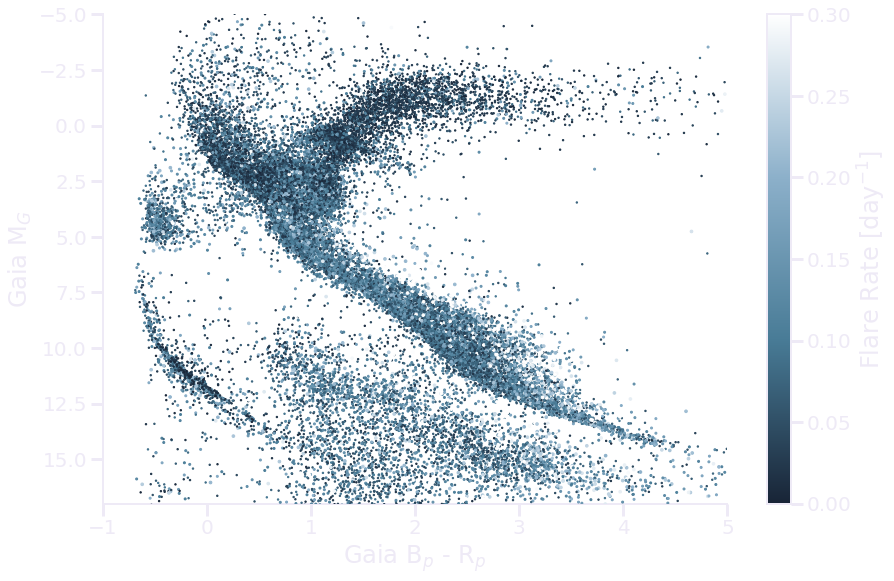

In [38]:
blue = present_cmap()

fig, ax1 = plt.subplots(figsize=(14,9), sharex=False)
#fig.set_facecolor('k')
flaresvmin=0
flaresvmax=0.3

if COLOR == 'white':
    cmap = blue.reversed()
else:
    cmap = blue

im = ax1.scatter(stars['bp_rp'],
                 stars['M_G'],
                 c=stars['N_flares_per_day'],
                 s=s,
                 vmin=flaresvmin,
                 vmax=flaresvmax,
                 cmap=cmap.reversed(), 
                 zorder=3)
cbar = fig.colorbar(im)
cbar.set_label(label='Flare Rate [day$^{-1}$]', fontsize=24)
xticks = [-1,0,1,2,3,4,5]
upxticks = np.array([cmd_mass[cmd_bprp>=0][0],
                     cmd_mass[cmd_bprp>=2][0],
                     cmd_mass[cmd_bprp>=4][0]])
ax1.set_xlim(-1, 5)
ax1.set_xticks(xticks)

plt.ylim(17,-5)

"""
twinticks = [0.327, 1.21, 2.13, 2.78, 4.86]
ax2 = ax1.twiny()
ax2.set_xticks(twinticks)
ax2.set_xticklabels([])


types = ['A','F','G','K','M']
xvals = [-0.9, -0.1, 1, 1.9, 3.6]
for i in range(len(types)):
    ax1.text(y=-5.2, x=xvals[i], s=types[i])
ax1.text(y=-6.2, x=2, s='Spectral Type', va='center', ha='center')
"""

ax1.set_xlabel('Gaia B$_p$ - R$_p$', fontsize=24)
ax1.set_ylabel('Gaia M$_G$', fontsize=24)
plt.subplots_adjust(hspace=0.1)
ax1.set_rasterized(True)
plt.savefig(os.path.join(figdir,'hr_dark_present.png'), rasterize=True, 
            bbox_inches='tight', dpi=300, transparent=True)

## Down select to the Main Sequence

In [18]:
model = dist_to_ms(stars, starbins)
ms_dist = np.abs(stars['M_G'] - model(stars['bp_rp']))
ms_dist_all = np.abs(allflares['M_G']-model(allflares['bp_rp']))

# Measuring Slopes -- Full Sample

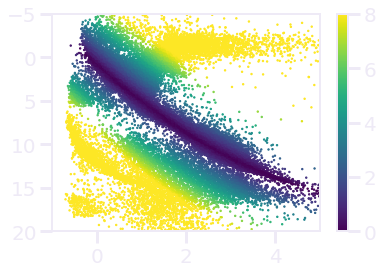

In [19]:
absmag = stars['M_G'] + 0.0

plt.scatter(stars['bp_rp'], absmag,
            c=np.abs(absmag - model(stars['bp_rp'])),
            s=2, vmin=0, vmax=8)
plt.ylim(20,-5)
plt.xlim(-1,5)
plt.colorbar()
ms_dist = np.abs(stars['M_G'] - model(stars['bp_rp']))
ms_dist_all = np.abs(allflares['M_G']-model(allflares['bp_rp']))

In [20]:
g_dist, g_dist_all = dist_to_giant(stars, allflares, ms_dist, ms_dist_all)

### Initial Guesses

In [23]:
init_slopes = np.zeros(len(starbins))
init_binsizes = np.zeros(len(starbins))
init_offsets = np.zeros(len(starbins))

dat_collection = []

bins = np.logspace(np.log10(1), np.log10(500),20)

for i in range(len(starbins)):
      
    if i < len(starbins)-1:
        
        inds = np.where((cmd_mass>=starbins[i]) & (cmd_mass<starbins[i+1]))[0]
    
        if i == 1 or i == 3:
            lowlim = previous + 0.0
        else:
            lowlim = cmd_bprp[inds][-1] + 0.0
    
        dat = allflares[(allflares['bp_rp']>= cmd_bprp[inds][0]) &
                        (allflares['bp_rp']<=  lowlim) &
                        (ms_dist_all < 2) & (allflares['prob']>=0.5)]


        s = stars[(stars['bp_rp']>= cmd_bprp[inds][0]) &
                  (stars['bp_rp']<  lowlim) &
                  (ms_dist < 2)]
        
        print('$[', cmd_bprp[inds][0],',', lowlim, ']$ & $[', 
              starbins[i], ',', starbins[i+1], 
             ']$ &', len(s), '&', len(dat))#, '&', len(d))
        
    else:
        dat = allflares[(g_dist_all < 3) & (allflares['prob']>=0.5)]
        s = stars[(g_dist < 2)]
    
        print('giants', len(s), '&', len(dat))
    
    if i < 2:
        slope, n, offset = amp_slope_fit(dat, 
                                              bins=bins, i=5, plot=False, get_err=False)
        
    else:
        slope, n, offset = amp_slope_fit(dat, 
                                              bins=bins, plot=False, get_err=False)
        
    init_slopes[i] = slope
    init_binsizes[i] = len(dat)
    init_offsets[i] = offset
    
    dat_collection.append(dat)

    previous = cmd_bprp[inds][0]
    
    print(slope)
    print('---')

$[ 2.78 , 4.86 ]$ & $[ 0.05 , 0.3 ]$ & 9241 & 59150
-1.2872616701500808
---
$[ 2.13 , 2.78 ]$ & $[ 0.3 , 0.5 ]$ & 20124 & 108963
-1.5946617895016886
---
$[ 1.21 , 2.09 ]$ & $[ 0.5 , 0.8 ]$ & 17914 & 139445
-1.6527348810276814
---
$[ 0.377 , 1.21 ]$ & $[ 0.8 , 1.7 ]$ & 85609 & 571556
-2.4125210076758252
---
$[ -0.12 , 0.327 ]$ & $[ 1.7 , 3.0 ]$ & 3770 & 20447
-0.9383130968264995
---
giants 5157 & 10965
-1.2066594865280487
---


/Users/arcticfox/Documents/GitHub/flares_soc/scripts/tools.py:53: RuntimeWarning: divide by zero encountered in log10
  logn = np.log10(n)
/Users/arcticfox/Documents/GitHub/flares_soc/scripts/tools.py:35: RuntimeWarning: invalid value encountered in power
  fit = b * x**m


### Creates histogram bins

In [24]:
bins = np.logspace(np.log10(1), np.log10(500),20)
histplots = []
lowlim = []
upplim = []
for i in range(len(starbins)):

    fig, ax = plt.subplots(figsize=(10,10))
    dat = dat_collection[i][dat_collection[i]['prob']>=0.9]
    
    n = ax.hist(dat['amp']*100, bins=bins,
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])),
                 alpha=0.4)
    histplots.append(n)
    
    dat = dat_collection[i][dat_collection[i]['prob']>=0.99]
    
    n = ax.hist(dat['amp']*100, bins=bins, 
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])),
                 alpha=0.4)
    lowlim.append(n[0])
    
    dat = dat_collection[i][dat_collection[i]['prob']>0.5]
    
    n = ax.hist(dat['amp']*100, bins=bins, 
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])),
                 alpha=0.4)
    upplim.append(n[0])
    
    previous = cmd_bprp[inds][0] + 0.0

    plt.yscale('log')
    plt.xscale('log')
    plt.close()

## MCMC fits

100%|██████████| 5000/5000 [00:31<00:00, 158.32it/s]


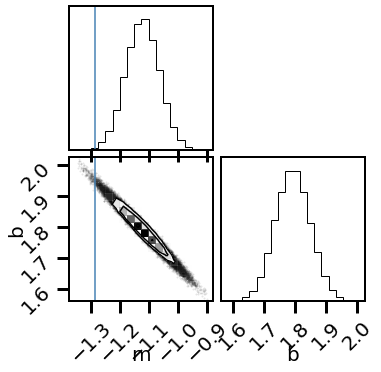

  0%|          | 16/5000 [00:00<00:31, 158.92it/s]

0 [-1.123808568700218, 0.05818284781253591, 0.05781181419478432] [1.7919688978368518, 0.0568846760781454, 0.05728121868583136]


100%|██████████| 5000/5000 [00:30<00:00, 163.97it/s]


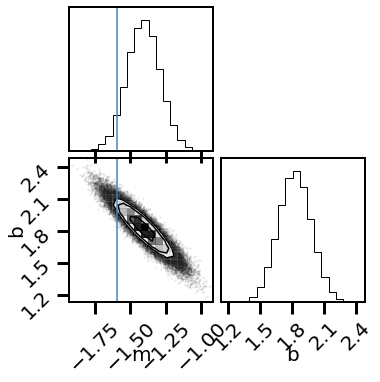

100%|██████████| 5000/5000 [00:31<00:00, 160.17it/s]


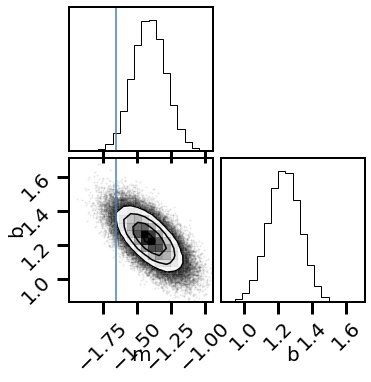

  0%|          | 15/5000 [00:00<00:33, 148.86it/s]

2 [-1.4077777844113317, 0.12086746299875428, 0.12188866412089627] [1.2360587643753225, 0.09518591230972118, 0.095032056957842]


100%|██████████| 5000/5000 [00:30<00:00, 164.04it/s]


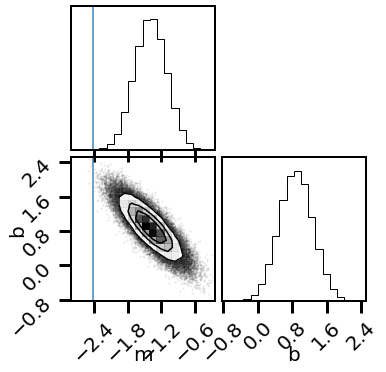

  0%|          | 16/5000 [00:00<00:32, 155.10it/s]

3 [-1.3935222916635326, 0.28457566674599555, 0.2859358898775317] [0.8833502955406515, 0.39007810966380235, 0.39129197293937634]


100%|██████████| 5000/5000 [00:33<00:00, 151.06it/s]


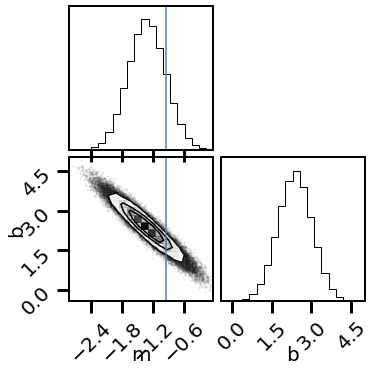

  0%|          | 13/5000 [00:00<00:39, 126.97it/s]

4 [-1.318764566429259, 0.3644329699258131, 0.36661406211565295] [2.37419920979723, 0.6509322592648623, 0.6440887531224146]


100%|██████████| 5000/5000 [00:32<00:00, 152.80it/s]


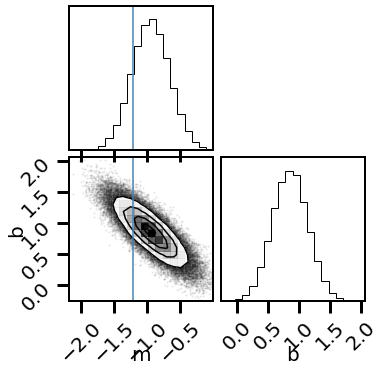

5 [-0.9488601880320136, 0.2842461127286655, 0.2846413934881322] [0.8560550337490458, 0.28630031167856984, 0.28698189777024363]
[[-1.12380857  0.05818285  0.05781181]
 [-1.40770152  0.11686402  0.11636948]
 [-1.40777778  0.12086746  0.12188866]
 [-1.39352229  0.28457567  0.28593589]
 [-1.31876457  0.36443297  0.36661406]
 [-0.94886019  0.28424611  0.28464139]]


In [287]:
mcmc_fits = np.zeros((len(init_slopes),3))
all_samples = []
mcmc_offsets = np.zeros((len(init_slopes),3))

np.random.seed(123)

for i in range(len(init_slopes)):

    x = (histplots[i][1][:-1] + histplots[i][1][1:]) / 2
    y = histplots[i][0] + 0.0
    initguess = [init_slopes[i], init_offsets[i]]

    if i == 0 or i == 4:
        samples, fits, offsets = run_mcmc(x, y, 
                                 lowlim[i], upplim[i], 
                                 initguess, 
                                 mask=np.arange(5,len(x)-1,1,dtype=int), 
                                 plot_chains=False)
        print(i, fits, offsets)
        mcmc_fits[i] = fits
        mcmc_offsets[i] = offsets
    elif i == 1:
        samples, fits, offsets = run_mcmc(x, y, 
                                 lowlim[i], upplim[i], 
                                 initguess, 
                                 mask=np.arange(4,len(x)-1,1,dtype=int), 
                                 plot_chains=False)
        mcmc_fits[i] = fits
        mcmc_offsets[i] = offsets
    elif i == 2 or i == 3:
        samples, fits, offsets = run_mcmc(x, y, 
                                 lowlim[i], upplim[i], 
                                 initguess, 
                                 mask=np.arange(0,len(x)-1,1,dtype=int), 
                                 plot_chains=False)
        print(i, fits, offsets)
        mcmc_fits[i] = fits
        mcmc_offsets[i] = offsets
    else:
        samples, fits, offsets = run_mcmc(x, y, 
                                 lowlim[i], upplim[i], 
                                 initguess, 
                                 mask=np.arange(0,len(y)-4,1,dtype=int),
                                 plot_chains=False)
        print(i, fits, offsets)
        mcmc_fits[i] = fits
        mcmc_offsets[i] = offsets

    
    all_samples.append(samples)
print(mcmc_fits)
np.save('mcmc_fits.npy', mcmc_fits)

/Users/arcticfox/Documents/flares/criticality/plot.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(starbins)


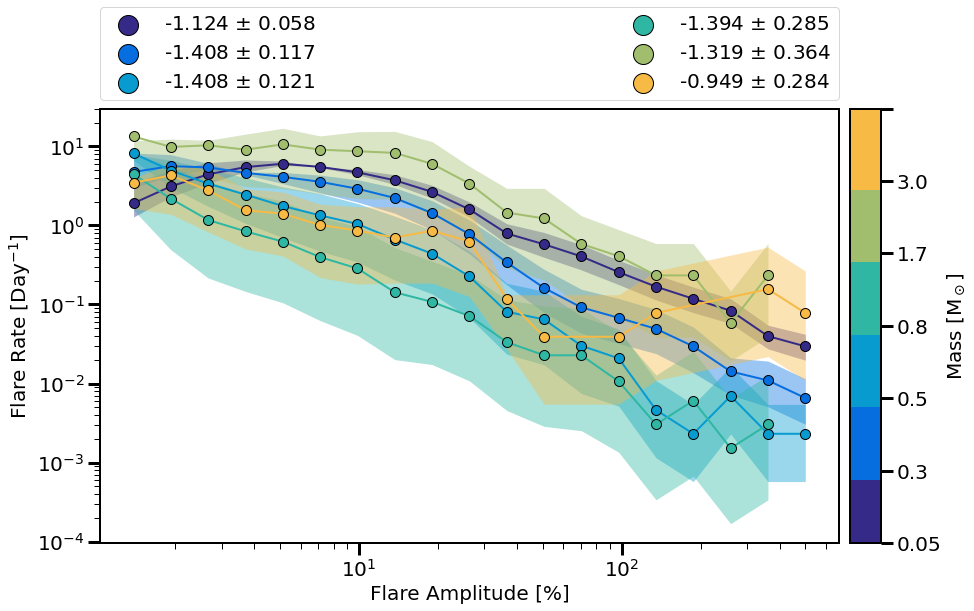

In [289]:
plot_slopes(histplots, lowlim, upplim, mcmc_fits, starbins, save=False)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


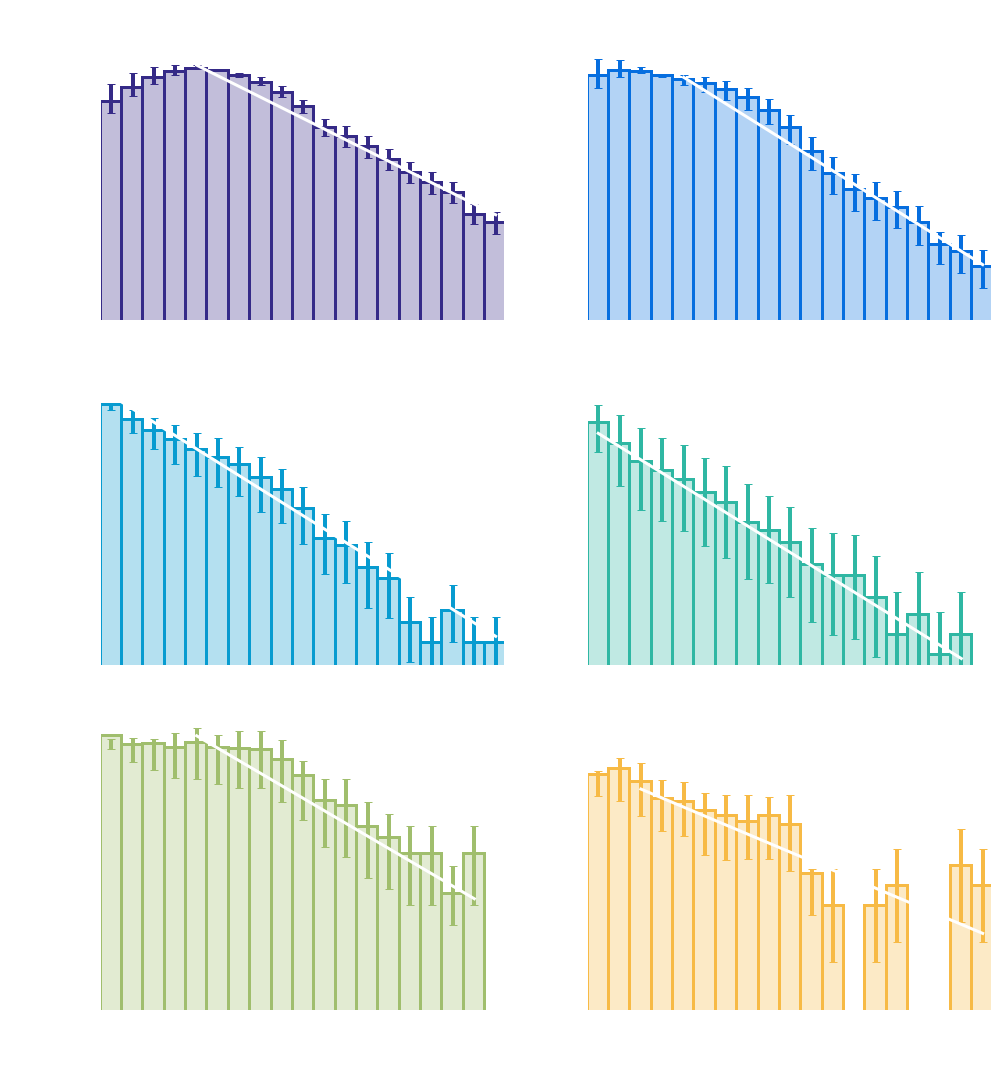

In [50]:
mcmc_fits = np.load('../catalogs/mcmc_fits.npy')

parula, cinds, oppo = parula_cmap(histplots)
fig, axes = plt.subplots(figsize=(16,18), ncols=2, nrows=3,
                                                         sharex=True, sharey=True)
#fig.set_facecolor('w')
cinds = parula[np.linspace(0, 210, len(histplots), dtype=int)]
add_offset=np.full(len(cinds), 10)
add_offset[0] += 20
add_offset[-2] += 80
add_offset[3] -= 10
add_offset[1] += 20
add_offset[-1] -= 8

i = 0
for ax in axes.reshape(-1):
    q = histplots[i][0] > 0
    dat = dat_collection[i][dat_collection[i]['prob']>=0.9]
    
    
    ax.hist(dat['amp']*100, bins=bins,
            weights=np.full(len(dat['amp']),
                            1.0/np.nansum(dat['weights'])),
            alpha=0.3, color=cinds[i])
    ax.hist(dat['amp']*100, bins=bins, color=cinds[i], 
                 edgecolor=cinds[i], linewidth=3,fill=None,
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])))#,
    
    ax.text(s=r'$\alpha$ = {0} $\pm$ {1}'.format(np.abs(np.round(mcmc_fits[i][0],3)),
                                                  np.round(mcmc_fits[i][1], 3)),
            x=24, y=7)
    
    binmid = center = (histplots[i][1][:-1] + histplots[i][1][1:]) / 2
    ax.errorbar(binmid[q], histplots[i][0][q], 
                yerr=(histplots[i][0][q]-lowlim[i][q], 
                      upplim[i][q]-histplots[i][0][q]),
                marker='o', c=cinds[i], 
                capsize=4, ms=0,
                linestyle='', lw=4)
    
    pl = power_law((mcmc_fits[i][0], 
                    np.log10(init_offsets[i])+add_offset[i]), 
                   binmid)
    if i == 0 or i == 4 or i == 1:
        ax.plot(binmid[q][4:], pl[q][4:], COLOR, lw=3)
    elif i == 2 or i == 3:
        ax.plot(binmid[q], pl[q], COLOR, lw=3)
    else:
        ax.plot(binmid[q][2:], pl[q][2:], COLOR, lw=3)
    
    if i % 2 == 0:
        ax.set_ylabel('Flare Rate [Day$^{-1}$]')
    if i > 3:
        ax.set_xlabel('Flare Amplitude [%]')
        
    if i == 0:
        ax.set_title('{} $\leq M/M_\odot \leq$ {}'.format(starbins[i], starbins[i+1]))
    elif i < 5:
        ax.set_title('{} $< M/M_\odot \leq$ {}'.format(starbins[i], starbins[i+1]))
    else:
        ax.set_title('Red Giant Branch')
    ax.set_rasterized(True)
    i += 1
    
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-3, 20)
plt.xlim(1,500)

plt.savefig(os.path.join(figdir, 'histograms_dark.pdf'), rasterize=True, 
            bbox_inches='tight', dpi=300, transparent=True)

### Presentation figure orientation

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


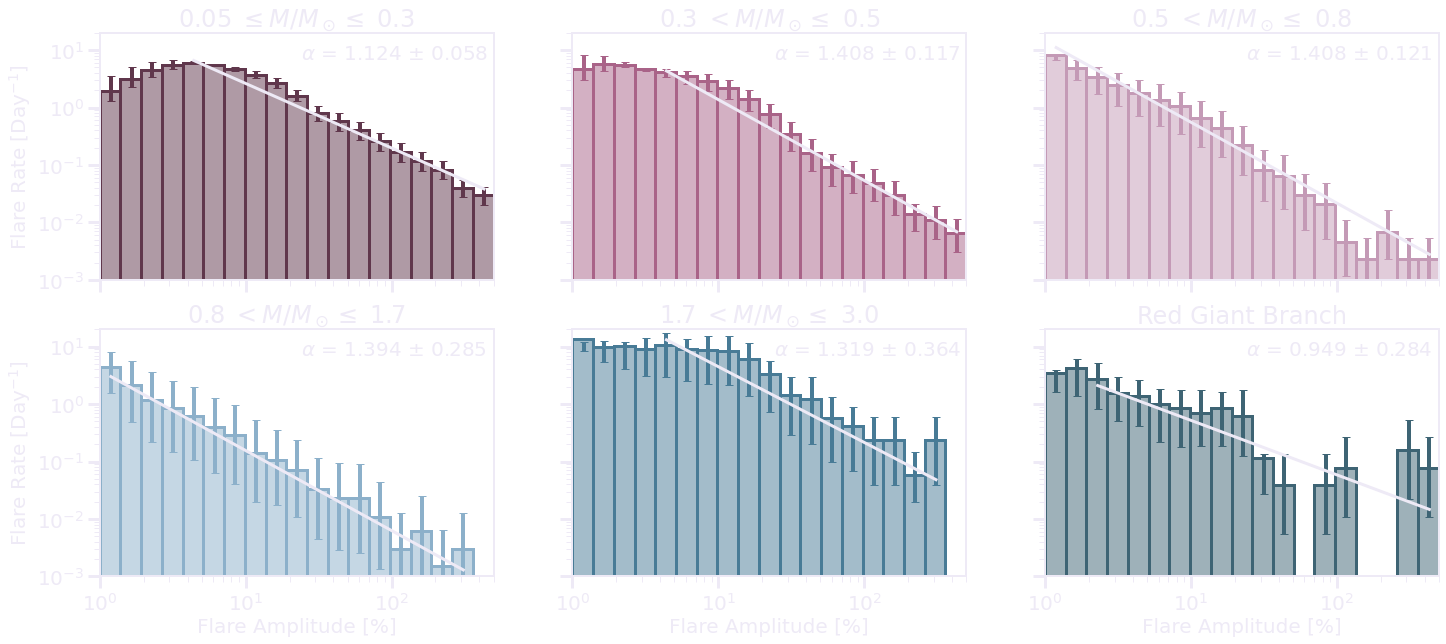

In [47]:
mcmc_fits = np.load('../catalogs/mcmc_fits.npy')

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True

_, cinds, _ = discrete_cmap()
fig, axes = plt.subplots(figsize=(24,10), ncols=3, nrows=2,
                                                         sharex=True, sharey=True)
#fig.set_facecolor('w')
#cinds = parula[np.linspace(0, 210, len(histplots), dtype=int)]
add_offset=np.full(len(cinds), 10)
add_offset[0] += 20
add_offset[-2] += 80
add_offset[3] -= 10
add_offset[1] += 20
add_offset[-1] -= 8

i = 0
for ax in axes.reshape(-1):
    q = histplots[i][0] > 0
    dat = dat_collection[i][dat_collection[i]['prob']>=0.9]
    
    
    ax.hist(dat['amp']*100, bins=bins,
            weights=np.full(len(dat['amp']),
                            1.0/np.nansum(dat['weights'])),
            alpha=0.5, color=cinds[i])
    ax.hist(dat['amp']*100, bins=bins, color=cinds[i], 
                 edgecolor=cinds[i], linewidth=3,fill=None,
                 weights=np.full(len(dat['amp']),
                                 1.0/np.nansum(dat['weights'])))#,
    
    ax.text(s=r'$\alpha$ = {0} $\pm$ {1}'.format(np.abs(np.round(mcmc_fits[i][0],3)),
                                                  np.round(mcmc_fits[i][1], 3)),
            x=24, y=7)
    
    binmid = center = (histplots[i][1][:-1] + histplots[i][1][1:]) / 2
    ax.errorbar(binmid[q], histplots[i][0][q], 
                yerr=(histplots[i][0][q]-lowlim[i][q], 
                      upplim[i][q]-histplots[i][0][q]),
                marker='o', c=cinds[i], 
                capsize=4, ms=0,
                linestyle='', lw=4)
    
    pl = power_law((mcmc_fits[i][0], 
                    np.log10(init_offsets[i])+add_offset[i]), 
                   binmid)
    if i == 0 or i == 4 or i == 1:
        ax.plot(binmid[q][4:], pl[q][4:], COLOR, lw=3)
    elif i == 2 or i == 3:
        ax.plot(binmid[q], pl[q], COLOR, lw=3)
    else:
        ax.plot(binmid[q][2:], pl[q][2:], COLOR, lw=3)
    
    if i == 0 or i == 3:
        ax.set_ylabel('Flare Rate [Day$^{-1}$]')
    if i >= 3:
        ax.set_xlabel('Flare Amplitude [%]')
        
    if i == 0:
        ax.set_title('{} $\leq M/M_\odot \leq$ {}'.format(starbins[i], starbins[i+1]))
    elif i < 5:
        ax.set_title('{} $< M/M_\odot \leq$ {}'.format(starbins[i], starbins[i+1]))
    else:
        ax.set_title('Red Giant Branch')
    ax.set_rasterized(True)
    i += 1
    
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-3, 20)
plt.xlim(1,500)

plt.savefig(os.path.join(figdir, 'histograms_present.png'), rasterize=True, 
            bbox_inches='tight', dpi=300, transparent=True)

In [144]:
np.save('../catalogs/mcmc_fits_high.npy', mcmc_fits_high)
np.save('../catalogs/mcmc_fits_low.npy', mcmc_fits_low)
np.save('../catalogs/mcmc_fits.npy', mcmc_fits)

## Comparison

In [56]:
import numpy as np

In [48]:
mcmc_fits_high = np.load('../catalogs/mcmc_fits_high.npy', allow_pickle=True)
mcmc_fits_low  = np.load('../catalogs/mcmc_fits_low.npy', allow_pickle=True)
mcmc_fits = np.load('../catalogs/mcmc_fits.npy', allow_pickle=True)

In [49]:
lit = Table.read('../catalogs/lit_flares.csv', format='csv')
avgmass = np.zeros(len(lit))
massrange = np.zeros(len(lit))

for i in range(len(lit)):
    ran = [int(i) for i in lit['teff'][i].split('-')]
    mask = (cmd_teff>=ran[0]) & (cmd_teff<=ran[1])
    avgmass[i] = (cmd_mass[mask][-1]+cmd_mass[mask][0]) / 2.0

    massrange[i] = np.nanmedian([cmd_mass[mask][0]-avgmass[i], avgmass[i]-cmd_mass[mask][-1]])
lit.add_column(Column(avgmass, 'avg_mass'))
lit.add_column(Column(massrange, 'mass_range'))
#lit.add_column

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


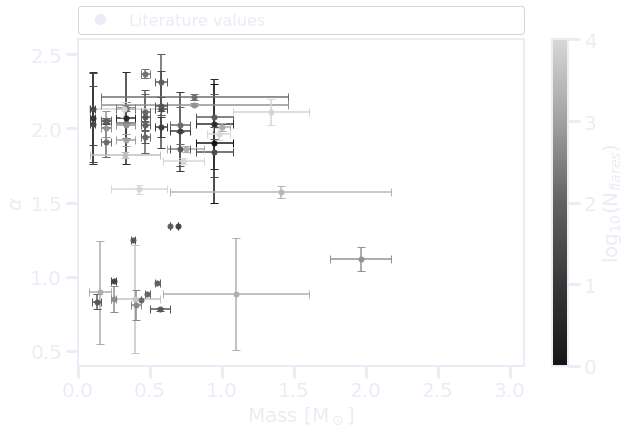

In [59]:
fig = plt.figure(figsize=(10,6))
#fig.set_facecolor('k')
logn = np.log10(lit['nflares']) +0.0

import matplotlib
import matplotlib.cm as cm


glist = ['#141413','#383737', '#636261', '#a3a1a0', '#d9d7d6']
mygray = make_cmap(glist, name='mygray')
norm = matplotlib.colors.Normalize(vmin=min(logn), vmax=4, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=mygray)
scattercolors = np.array([(mapper.to_rgba(v)) for v in logn])


for i in range(len(lit)):
    plt.errorbar(lit['avg_mass'][i],
                 lit['slope'][i],
                 xerr=lit['mass_range'][i],
                 yerr=lit['error'][i], capsize=4, 
                 marker='o', linestyle='', color=scattercolors[i], ms=5)
"""
lw=3
for i in range(len(mcmc_fits)):
    try:
        avg = (starbins[i]+starbins[i+1])/2
        merr = np.nanmedian([avg-starbins[i], starbins[i+1]-avg])
    except:
        avg = (0.8+1.8)/2
        merr = np.nanmedian([avg-0.8, 1.8-avg])
    (_, caps, _) = plt.errorbar(avg,
                                 np.abs(mcmc_fits[i][0]),
                                 xerr=merr,
                                 yerr=mcmc_fits[i][1],# mcmc_fits[i][2]),
                                 marker='*', linestyle='', color=cinds[i], ms=25,
                                 zorder=200, capsize=4, markeredgecolor='#0C121C', 
                                 lw=lw)
    for cap in caps:
        cap.set_markeredgewidth(lw)
        
        
plt.plot(-1,0, '*', ms=10, c=COLOR, markeredgecolor=COLOR, lw=2, label='Our sample')
"""
plt.plot(-1,0, 'o', ms=5, c=COLOR, markeredgecolor=COLOR, lw=2, label='Literature values')
plt.xlim(0,3.1)
plt.ylim(0.4,2.6)
plt.legend(ncol=2, bbox_to_anchor=(0., 1.0, 1., .102), fontsize=16, 
           loc='upper left', borderaxespad=0., mode="expand")

sc = plt.scatter(lit['avg_mass'],lit['slope'],s=0, c=logn, cmap=mygray, vmax=4)
clb = plt.colorbar(sc, label=r'log$_{10}$(N$_{flares}$)')
clb.set_ticks(np.arange(0,5,1))
plt.ylabel(r'$\alpha$')
plt.xlabel(r'Mass [M$_\odot$]')
plt.savefig(os.path.join(figdir, 'comparison_dark_present_without.png'), transparent=True,
            dpi=300, rasterize=True, bbox_inches='tight')